In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, KFold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error, median_absolute_error

In [88]:
data = pd.read_pickle('optional_features.pkl')

## EXPERIMENTS
#### 1. Removing of outliers
results of test: (Train R² / Test R² / MSE / RMSE)

a) no outlier removal: model fits well, but affected by large outliers (0.56, 0.53, 467.04, 21.61)

b) remove x and y outliers: low error, but model trained on less data (0.32, 0.34, 1.72, 1.31) 

c) clip only the target value: balanced — outliers controlled, full dataset used (0.49, 0.48, 3.91, 1.98)
##### Conclusion: Clipping only the target value when removing outliers performed the best but not as well as other methods, removed to be able to compare metrics between models 

#### 2. Log transform target value
##### Conclusion: This resulted in very poor results and a negative r^2 value and so we opted to not log tranform the y-values 

#### 3. Apply L2 (Ridge) regularization
LIN REGRESSION:

Cross-Validation R² scores: [0.52861575 0.64822492 0.53559273 0.59577063 0.44102323]

Average R²: 0.5498454526343786

Mean Squared Error: 479.11

RMSE: 21.89

Mean Absolute Error: 6.48

R² Score: 0.52

RIDGE:

Cross-Validation R² scores: [0.5286789  0.64818756 0.53563138 0.59574145 0.44099878]

Average R²: 0.5498476139621546

Mean Squared Error: 479.09

RMSE: 21.89

Mean Absolute Error: 6.48

R² Score: 0.52

##### Conclusion: This resulted in similar results to linear regression and we added a flag to compare results within the same notebook

#### 4. Cross-validation
##### Conclusion: This resulted in similar results through iterations as shown above

#### 5. Apply PCA

LinReg Regression with PCA Results

Train R²: 0.5484

Test R²: 0.5165

Ridge Regression with PCA Results

Train R²: 0.5484

Test R²: 0.5165

##### Conclusion: Performance was almost the same with and without PCA but we were able to visualize and learn the optimal number of components and keep PCA

#### 6. From our learnings in DataPreprocessing.ipynb, apply an autoencoder with encoder dimension = 32, hidden layer size = 128
##### Conclusion: Performed the best, results shown below:
<----Linear Regression after autoencoder---->
Root mean Squared Error: 21.0687

Mean absolute Error: 5.4965

Mean Squared Error: 443.89

Median absolute Error: 2.1101

R² Score: 0.5408

In [89]:
# separate features and target
X = data.drop(columns=["Target_Comment_Volume"])
y = data["Target_Comment_Volume"]

# Experiment 1: we clip only the target value when removing outliers
# Q1 = y.quantile(0.25)
# Q3 = y.quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR
# non_outliers = (y >= lower_bound) & (y <= upper_bound)
# y = np.clip(y, lower_bound, upper_bound)

# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # scale before splitting train-test so that all values are in the same range

In [90]:
model_train_flag = "Ridge" # either LinReg or Ridge

In [91]:
# PCA
pca = PCA(n_components=0.95)  # retain 95% variances

if model_train_flag == "LinReg":
    pipeline = Pipeline([
        ('pca', pca),
        ('reg', LinearRegression())
    ])
elif model_train_flag == "Ridge":
    pipeline = Pipeline([
        ('pca', pca),
        ('reg', Ridge(alpha=10))
    ])

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1)  # setting random_state allows for the same split on each run

In [93]:
# fit pipeline
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [94]:
# evaluation
print(f"{model_train_flag} Regression with PCA Results")
print(f"Train R²: {pipeline.score(X_train, y_train):.4f}")
print(f"Test R²: {pipeline.score(X_test, y_test):.4f}")

Ridge Regression with PCA Results
Train R²: 0.9029
Test R²: 0.8907


In [95]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_scaled, y, scoring='r2', cv=cv)
print("Cross-Validation R² scores:", cv_scores)
print("Average R²:", np.mean(cv_scores))

mse = mean_squared_error(y_test, y_pred)  # lec 4, slide 20
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Cross-Validation R² scores: [0.89557123 0.89428853 0.85176965 0.91234399 0.8708799 ]
Average R²: 0.8849706598953565
Mean Squared Error: 114.38
RMSE: 10.69
Mean Absolute Error: 2.44
R² Score: 0.89


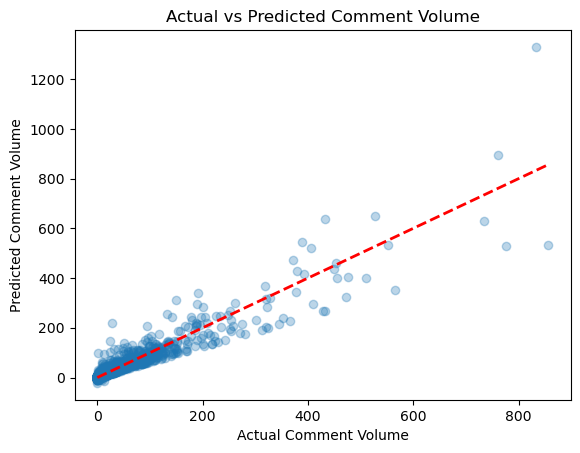

In [96]:
# best = points close to the diagonal
plt.scatter(y_test, y_pred, alpha=0.3)  # alpha=0.3 for semi-transparent dots
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # red diagonal line
plt.xlabel("Actual Comment Volume")
plt.ylabel("Predicted Comment Volume")
plt.title("Actual vs Predicted Comment Volume")
plt.show()


### Summary
Linear regression proves as a good baseline model and we ran multiple experiments to play around with what would give us the best result.